In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import transformers
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModel,
    BartModel,
    BartForConditionalGeneration,
    AutoModelForSequenceClassification,
    Trainer, TrainingArguments,
    pipeline,
    BertTokenizerFast, BertForSequenceClassification
)
from gradio import Interface
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


2024-04-21 00:18:54.903558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [3]:
BATCH_SIZE = 16

### Dataset

In [17]:
"""LOAD FROM PROCESSED DATA"""

'LOAD FROM PROCESSED DATA'

In [4]:
dataset = load_dataset("mahfoos/Patient-Doctor-Conversation")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Description', 'Doctor', 'Patient', 'Status'],
        num_rows: 3325
    })
})

In [6]:
dataset["train"].select_columns(["Patient", "Status"])

Dataset({
    features: ['Patient', 'Status'],
    num_rows: 3325
})

In [7]:
pd_dataset = pd.DataFrame(dataset["train"].select_columns(["Patient", "Status"]))

In [8]:
pd_dataset

,Patient,Status
0,hi doctor I am just wondering what is abutting...,medium severity
1,hi doctor I am a 26 year old male I am feet an...,high severity
2,hello doctor I am 48 years old I am experienci...,low severity
3,hello doctor I have multiple small cysts in bo...,medium severity
4,hi doctor during masturbation I just rub the t...,low severity
...,...,...
3320,hello doctor I am currently seeking help and I...,high severity
3321,hi doctor I fell on a wooden set of stairs las...,medium severity
3322,hi doctor my mother is 57 years old she has re...,low severity
3323,hi doctor my 18 month old daughter has had pro...,medium severity


In [9]:
label_map = {"high severity": 0, "medium severity": 1, "low severity": 2}
pd_dataset["Status"] = pd_dataset["Status"].replace(label_map)

In [10]:
pd_dataset.iloc[0]

Patient    hi doctor I am just wondering what is abutting...
Status                                                     1
Name: 0, dtype: object

In [11]:
pd_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3325 entries, 0 to 3324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Patient  3325 non-null   object
 1   Status   3325 non-null   object
dtypes: object(2)
memory usage: 52.1+ KB


In [12]:
pd_dataset["Status"] = pd_dataset["Status"].astype(str)

In [13]:
pd_dataset.head()

,Patient,Status
0,hi doctor I am just wondering what is abutting...,1
1,hi doctor I am a 26 year old male I am feet an...,0
2,hello doctor I am 48 years old I am experienci...,2
3,hello doctor I have multiple small cysts in bo...,1
4,hi doctor during masturbation I just rub the t...,2


In [16]:
train_data, test_data = train_test_split(pd_dataset, test_size=0.2, random_state=42)

train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [14]:
train_data.shape

(2394, 2)

In [15]:
test_data.shape

(665, 2)

In [16]:
valid_data.shape

(266, 2)

In [17]:
pd_dataset["Patient"].to_list()[4]

'hi doctor during masturbation I just rub the tip of the penis and not the entire penis is it a wrong way of doing I do not get excited during sex and unable to ejaculate only rubbing the tip of the penis gives me excitement also two weeks ago I have undergone circumcision as my foreskin did not retract before circumcision too I have the same problem please help'

In [18]:
class BioBERTDataset(TensorDataset):
    def __init__(self, data):
        super(BioBERTDataset, self).__init__()
        self.texts = data["Patient"].tolist()
        self.labels = data["Status"].to_list()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        return text, label

# M1

### Fine Tuning Model with Language Understanding 

In [18]:
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

feature_extractor = pipeline(
            task="feature-extraction",
            model=biobert_model,
            tokenizer=biobert_tokenizer,
            framework="pt"
        )

/home/jerlshin/env_ai/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [20]:
biobert_tokenizer.vocab_size

28996

In [21]:
biobert_tokenizer

BertTokenizerFast(name_or_path='dmis-lab/biobert-v1.1', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [22]:
biobert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [23]:
train_data.iloc[1]["Patient"]

'hello doctor I am having issues with hearing pain pressure and sensitivity to noise can slough in ear be painful I am currently using topamax allegra baby aspirin tylenol aleve and ibuprofen'

In [24]:
train_data.iloc[1]["Status"]

'1'

In [32]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):    # data and tokenizer 
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 512
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # take dataset
        text = self.data.iloc[idx]["Patient"]
        label = int(self.data.iloc[idx]["Status"])

        # encoding 
        encoding = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)

        # take the input and the mask 
        input_ids = encoding["input_ids"].squeeze() # remove the empty dimenstion 
        attention_mask = encoding["attention_mask"].squeeze()

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = torch.tensor(label).to(device)

        return input_ids, attention_mask, label
    

# creating datasets
train_dataset = CustomDataset(train_data, biobert_tokenizer)
valid_dataset = CustomDataset(valid_data, biobert_tokenizer)
test_dataset = CustomDataset(test_data, biobert_tokenizer)


# creating dataloader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
train_dataset, train_dataloader

(<__main__.CustomDataset at 0x74c2bd4111e0>,
 <torch.utils.data.dataloader.DataLoader at 0x74c2bd4132e0>)

In [34]:
class BioBERTClass(nn.Module):
    def __init__(self):
        super(BioBERTClass, self).__init__()
        
        self.biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
        self.biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

        # self.feature_extractor = feature_extractor
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 3) # high, low, med 
    
    def forward(self, input_ids, attention_mask):
        # inputs = self.biobert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        # input_ids = inputs["input_ids"]
        # attention_mask = inputs["attention_mask"]

        # outputs = self.feature_extractor(text)
        outputs = self.biobert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        pre_clss = self.pre_classifier(pooled_output)
        pre_clss = torch.nn.functional.relu(pre_clss)
        pre_clss = self.dropout(pre_clss)
        logits = self.classifier(pre_clss)

        
        return logits
    

In [ ]:
for (input_ids, attention_mask, label) in train_dataloader:
    model = BioBERTClass()
    model.to(device)
    logits = model(input_ids, attention_mask)
    print(logits)
    print(label)
    break

### Infering Model outputs

In [83]:
text = "In most cases, using the pipeline is a more convenient and robust approach for feature extraction with BioBERT. It streamlines the process and reduces the potential for errors."


In [59]:
tok = biobert_tokenizer(text=text, return_attention_mask=True, return_tensors="pt")

In [60]:
tok

{'input_ids': tensor([[  101, 25267,  1110,  1126, 14918,  3340,   106,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [64]:
result = biobert_model(tok["input_ids"], attention_mask=tok["attention_mask"])

In [70]:
result.cross_attentions

In [71]:
result.hidden_states

In [72]:
result.last_hidden_state

tensor([[[ 0.5785,  0.6512, -0.1213,  ..., -0.1627,  0.5340, -0.0945],
         [ 0.2206,  0.2317, -0.5591,  ...,  0.0954,  0.2765,  0.1342],
         [ 0.4252,  0.7822,  0.2654,  ...,  0.0571,  0.5467, -0.0198],
         ...,
         [ 0.4598,  0.3177, -0.2936,  ...,  0.0017, -0.0205,  0.2446],
         [ 0.2431,  0.2347,  0.3534,  ...,  0.1866,  0.2375, -0.1035],
         [ 0.7031,  0.4518, -0.6258,  ...,  0.1520,  0.6689, -1.1636]]],
       grad_fn=<NativeLayerNormBackward0>)

In [67]:
result[0]

tensor([[[ 0.5785,  0.6512, -0.1213,  ..., -0.1627,  0.5340, -0.0945],
         [ 0.2206,  0.2317, -0.5591,  ...,  0.0954,  0.2765,  0.1342],
         [ 0.4252,  0.7822,  0.2654,  ...,  0.0571,  0.5467, -0.0198],
         ...,
         [ 0.4598,  0.3177, -0.2936,  ...,  0.0017, -0.0205,  0.2446],
         [ 0.2431,  0.2347,  0.3534,  ...,  0.1866,  0.2375, -0.1035],
         [ 0.7031,  0.4518, -0.6258,  ...,  0.1520,  0.6689, -1.1636]]],
       grad_fn=<NativeLayerNormBackward0>)

In [73]:
result.values

<function BaseModelOutputWithPoolingAndCrossAttentions.values>

In [74]:
result.attentions

In [75]:
result.pooler_output

tensor([[ 0.0327,  0.0473,  0.9227, -1.0000,  1.0000,  0.4457,  0.0973,  0.8852,
         -0.0636, -0.0211,  0.8452,  1.0000, -0.3038, -0.8659, -0.0688, -0.1158,
          1.0000,  0.1385, -0.9972, -0.1953, -0.2052, -0.9581, -0.0098,  0.9992,
         -0.1077, -0.0291,  1.0000,  0.9975,  0.0387, -0.0333, -0.0643, -1.0000,
          0.9871, -1.0000,  0.2207,  0.0517, -0.0165, -0.0924,  0.7320, -0.9987,
         -0.0388, -0.5510, -0.0134,  0.0413,  0.9998, -0.0168, -0.1356, -0.0703,
          0.0484,  0.4126,  0.0756,  0.9471,  0.3430,  0.9966,  0.9998,  0.0634,
          1.0000,  0.1296,  0.6168, -0.1301,  1.0000, -0.0605,  0.1722,  0.0146,
          0.0659,  0.0018, -0.9801,  0.0555,  0.0439, -0.0077,  0.0695, -0.0121,
          0.9985, -0.9999, -0.0817,  0.0432,  0.0633, -0.9157,  0.9994,  0.9999,
         -0.0636, -0.9975,  1.0000,  0.0529, -0.2195, -0.0039,  0.5829, -0.9999,
          0.0692, -0.0177,  0.8689, -1.0000,  0.0389, -0.6769,  0.9966,  0.3122,
         -0.0956,  0.2020,  

In [91]:
result = feature_extractor(text, return_tensors="pt")

In [92]:
print(result)

tensor([[[ 0.1214,  0.1994, -0.0806,  ..., -0.3956,  0.2209,  0.2493],
         [ 0.0408, -0.1670,  0.2204,  ...,  0.5409,  0.1506,  0.1340],
         [-0.5399, -0.0145,  0.3643,  ...,  0.4207, -0.0376,  0.7490],
         ...,
         [ 0.1597,  0.0467,  0.6930,  ...,  0.3340,  0.2768,  0.1968],
         [ 0.8585, -0.3516,  0.1469,  ..., -0.2806, -0.0955, -0.3273],
         [ 0.8624, -0.3524,  0.1438,  ..., -0.2812, -0.0974, -0.3292]]])


In [108]:
result.shape

torch.Size([1, 37, 768])

### Train

In [ ]:

criterion = nn.CrossEntropyLoss()

writer = SummaryWriter()

num_epochs = 2  
save_every = 2  

for epoch in range(num_epochs):

    model = BioBERTClass()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    """TRAIN"""
    model.train()
    running_loss = 0.0

    train_dataloader_iter = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_dataloader_iter):
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 100 == 99:   
            avg_loss = running_loss / 100
            writer.add_scalar("Training Loss", avg_loss, epoch * len(train_dataloader) + batch_idx)
            running_loss = 0.0
            train_dataloader_iter.set_postfix(loss=avg_loss)  # Update progress bar with average loss
    
    """VALIDATION"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels in valid_dataloader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_dataloader)
    accuracy = 100 * correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    writer.add_scalar("Validation Loss", avg_val_loss, epoch)
    writer.add_scalar("Validation Accuracy", accuracy, epoch)

    # Save the weights every 'save_every' epochs
    if (epoch + 1) % save_every == 0:
        torch.save(model.state_dict(), f"model_weights_epoch_{epoch + 1}.pt")
        print(f"Model weights saved at epoch {epoch + 1}")

print("Training finished")

writer.close()


# M2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [5]:
pd_dataset = pd.read_csv("./Patient_Doctor_Severity_Dataset.csv")

In [6]:
def clean_severity(text):
    text = text.lower().strip()
    if text == "low severity":
        return "low"
    elif text in ["medium severity", "medium severity:"]:
        return "medium"
    else:
        return "high"

pd_dataset["Status"] = pd_dataset["Status"].apply(clean_severity)

In [7]:
labels = pd_dataset["Status"].unique().tolist()
labels = [s.strip() for s in labels]
labels

['medium', 'high', 'low']

In [8]:
NUM_LABELS = len(labels)
BATCH_SIZE = 16

In [9]:
id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [10]:
selected_columns = ["Patient", "Status"]
df_org = pd_dataset[selected_columns]


In [11]:
df_org["Status"] = df_org['Status'].replace(label2id)
df_org.head()

/tmp/ipykernel_24890/1842054565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org["Status"] = df_org['Status'].replace(label2id)


,Patient,Status
0,hi doctor I am just wondering what is abutting...,0
1,hi doctor I am a 26 year old male I am feet an...,1
2,hello doctor I am 48 years old I am experienci...,2
3,hello doctor I have multiple small cysts in bo...,0
4,hi doctor during masturbation I just rub the t...,2


<AxesSubplot:ylabel='Status'>

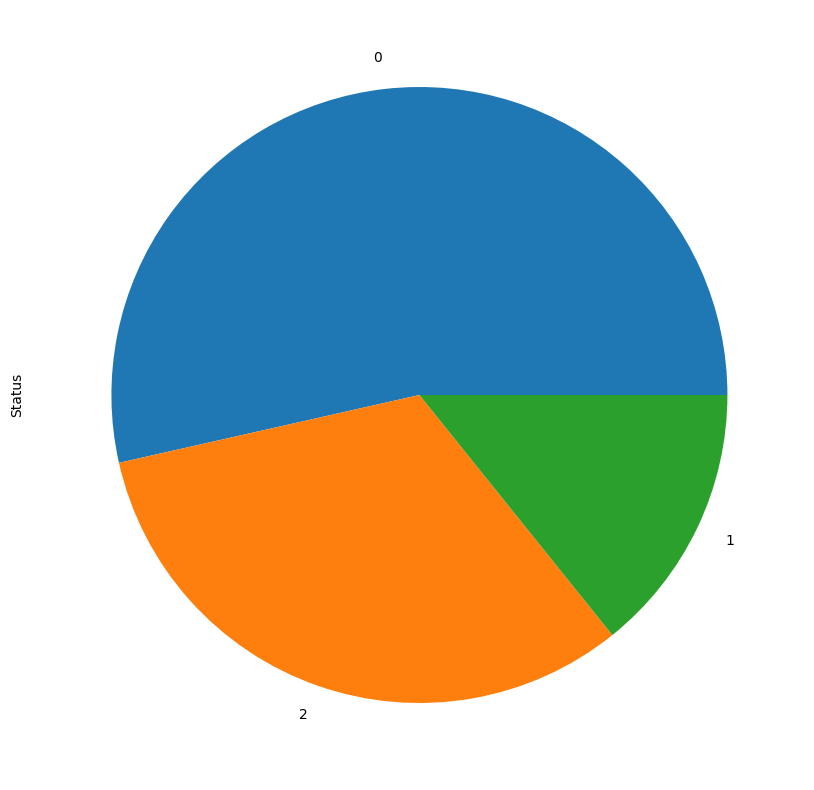

In [12]:
df_org.Status.value_counts().plot(kind='pie', figsize=(10,10))

In [17]:
tokenizer = BertTokenizerFast.from_pretrained(
    "bert-base-uncased", max_length=512
)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels=NUM_LABELS, id2label=id2label, label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

In [2]:
import os 
from kaggle.api.kaggle_api import KaggleApi

In [18]:
SIZE = df_org.shape[0]

train_texts = list(df_org.Patient[:SIZE//2])
val_texts = list(df_org.Patient[SIZE//2:(3*SIZE)//4 ])
test_texts = list(df_org.Patient[(3*SIZE)//4:])

train_labels = list(df_org.Status[:SIZE//2])
val_labels = list(df_org.Status[SIZE//2:(3*SIZE)//4])
test_labels = list(df_org.Status[(3*SIZE)//4:])

In [19]:
len(train_texts), len(val_texts), len(test_texts)

(1662, 831, 832)

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [21]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx): # return dict with tokenized data, and label
        # return as a tensor 
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} 
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [22]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataset = DataLoader(test_encodings, test_labels)

In [23]:
def compute_metrics(pred): # compute F1, Precision, recall
    labels = pred.label_ids # true 
    preds = pred.predictions.argmax(-1) # pred
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    acc = accuracy_score(labels, preds)
    # as a dict
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [25]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./MODEL_OUTPUT', 
    do_train=True,
    do_eval=True,
    num_train_epochs=20,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    warmup_steps=100,                # setps used for a linear warmup for learning rate 
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',  # tensorboard log dir            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model, # pretrained model to be fine tuned 
    
    args=training_args,                   # args 
    
    train_dataset=train_dataloader,     # datset
    eval_dataset=val_dataloader,            
    
    compute_metrics= compute_metrics # evaluation metrics
)

In [ ]:
# trainer.train()

In [ ]:
q = [trainer.evaluate(eval_dataset=df_org) 
     for df_org in [train_dataloader, val_dataloader, test_dataset]]

In [50]:
model_path = "patientRequestSummarization"

# FINE TUNED MODEL
finetuned_model = BertForSequenceClassification.from_pretrained(model_path)
finetuned_tokenizer= BertTokenizerFast.from_pretrained(model_path)

In [52]:
def predict(text):
    inputs = finetuned_tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = finetuned_model(**inputs)
    
    probs = outputs[0].softmax(1)   
    pred_label_idx = probs.argmax()
    
    pred_label = model.config.id2label[pred_label_idx.item()]
    return pred_label_idx, pred_label


In [53]:
for i in range(10):
    print(predict(train_texts[i]), train_labels[i])

(tensor(0), 'medium') 0
(tensor(1), 'high') 1
(tensor(2), 'low') 2
(tensor(0), 'medium') 0
(tensor(2), 'low') 2
(tensor(0), 'medium') 0
(tensor(2), 'low') 2
(tensor(0), 'medium') 0
(tensor(1), 'high') 1
(tensor(2), 'low') 2
